In [10]:
import numpy as np
import pandas as pd
import pandas
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as snc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix


# Task 3. Predicting default costs

### Start with reading and checking the data

In [3]:
credit_data = pd.read_csv('Task 3 and 4_Loan_Data.csv')
credit_data.head()



,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


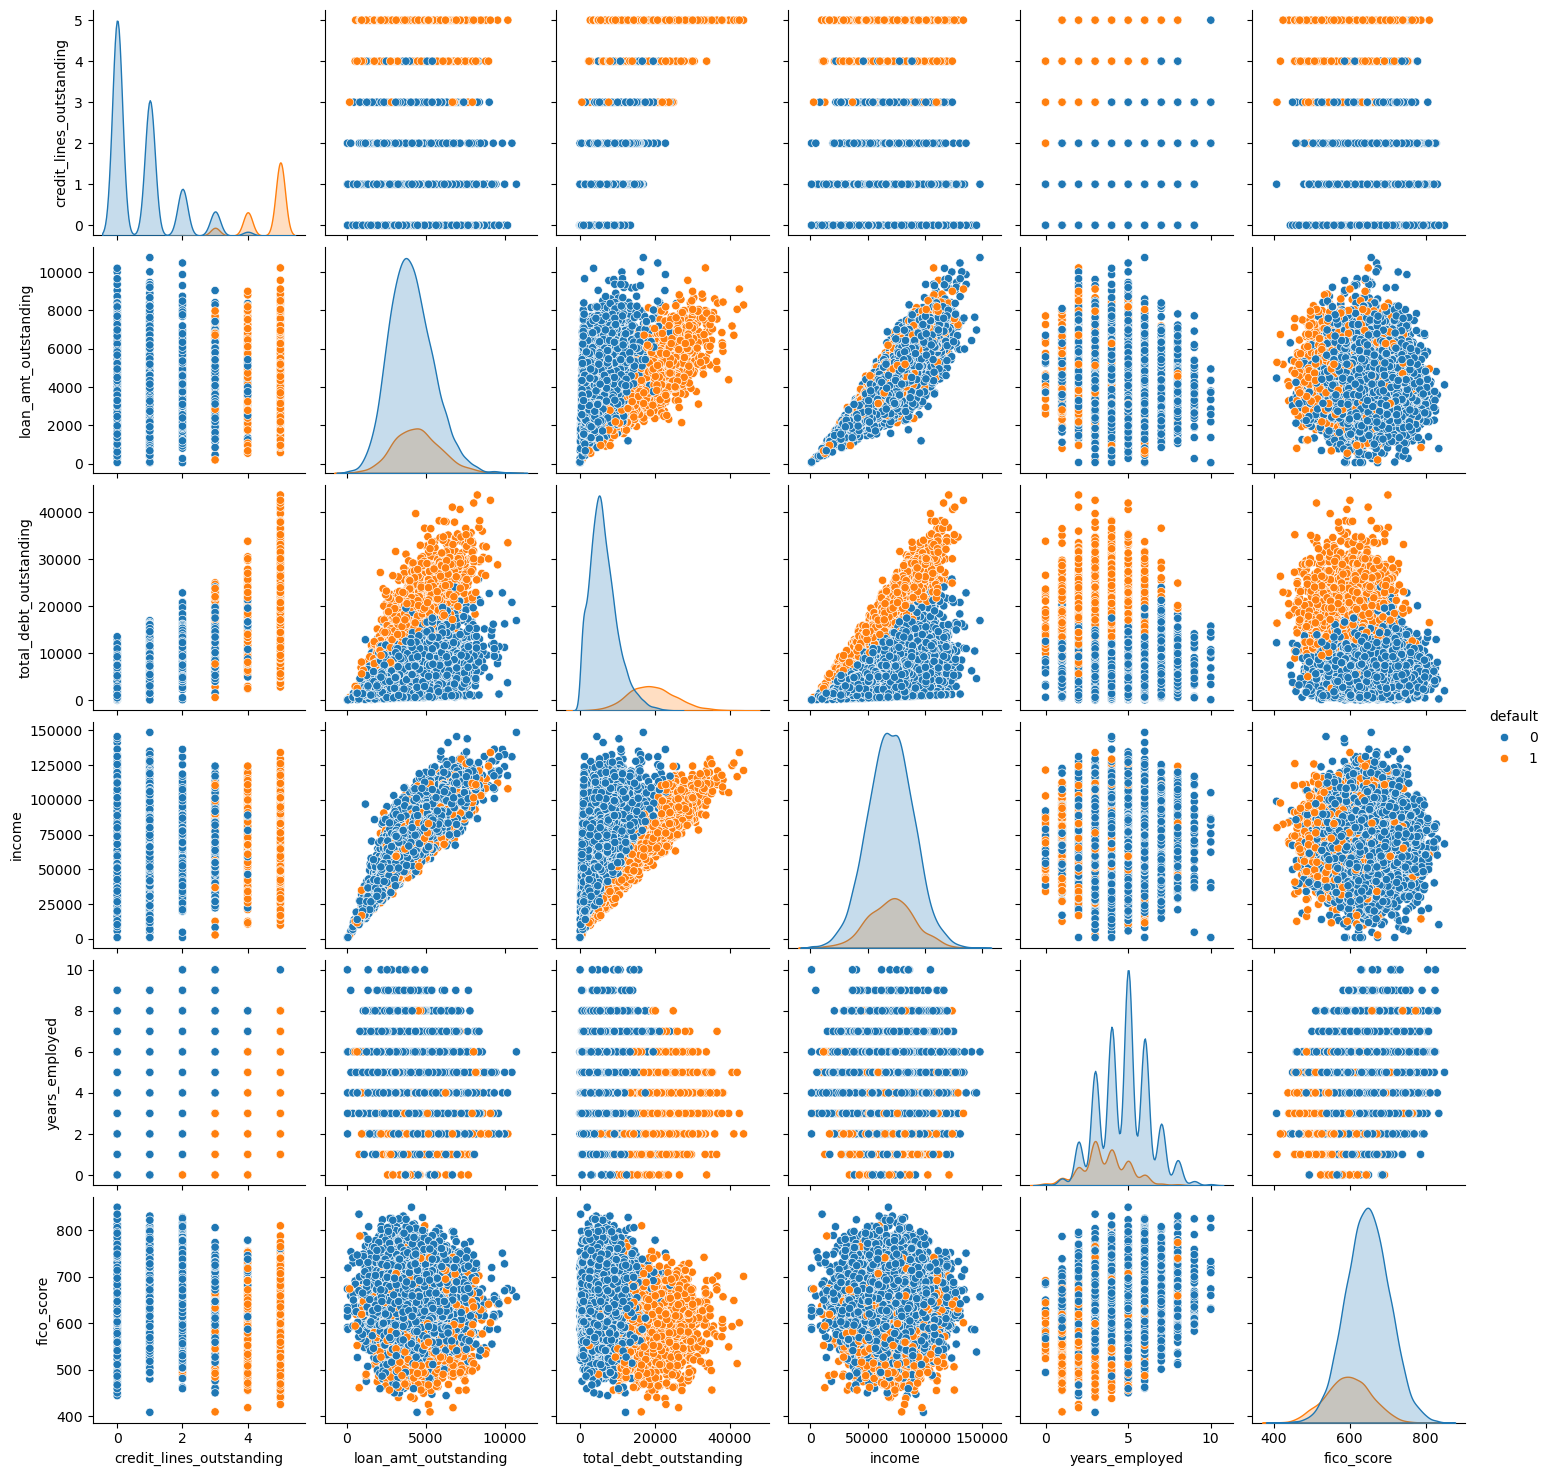

In [68]:
snc.pairplot(data= credit_data.drop(['customer_id'], axis = 1), hue="default")

There are some clear demarcations between customers that default and those that don't. Based on this, a decision tree may be a pretty effective model.

The clearest trends are:
1. The more credit lines outstanding, the higher the risk of default
2. If the ratio of debt to income is too high, the customer usually defaults

### Split data into train and test datasets

In [4]:
# separate data into features and target
X = credit_data.drop(['customer_id', 'default'], axis = 1)
Y = credit_data['default']
feature_names = ['credit_lines_outstanding',	'loan_amt_outstanding' ,\
                 	'total_debt_outstanding',	'income',	'years_employed',	'fico_score']

X_train , X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)




In [5]:
X_train.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score
1125,5,3756.979039,31083.466440,104146.22060,6,598
138,1,3726.430399,5573.155053,66898.13695,6,590
5518,4,3130.987411,10439.085040,44104.95803,3,522
7687,1,2956.124588,5638.130423,57206.50963,6,569
1270,3,3557.451002,12830.424380,77751.66385,5,572


### Model 1: Decision tree

Train our decision tree

[Text(0.5516581632653061, 0.9545454545454546, 'credit_lines_outstanding <= 3.5\ngini = 0.303\nsamples = 8000\nvalue = [6508, 1492]'),
 Text(0.22321428571428573, 0.8636363636363636, 'credit_lines_outstanding <= 2.5\ngini = 0.036\nsamples = 6575\nvalue = [6454, 121]'),
 Text(0.08163265306122448, 0.7727272727272727, 'years_employed <= 0.5\ngini = 0.002\nsamples = 6092\nvalue = [6087, 5]'),
 Text(0.04081632653061224, 0.6818181818181818, 'total_debt_outstanding <= 13537.895\ngini = 0.346\nsamples = 9\nvalue = [7, 2]'),
 Text(0.02040816326530612, 0.5909090909090909, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(0.061224489795918366, 0.5909090909090909, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.12244897959183673, 0.6818181818181818, 'years_employed <= 1.5\ngini = 0.001\nsamples = 6083\nvalue = [6080, 3]'),
 Text(0.10204081632653061, 0.5909090909090909, 'fico_score <= 547.5\ngini = 0.094\nsamples = 61\nvalue = [58, 3]'),
 Text(0.061224489795918366, 0.5, 'credit_lines_outstanding 

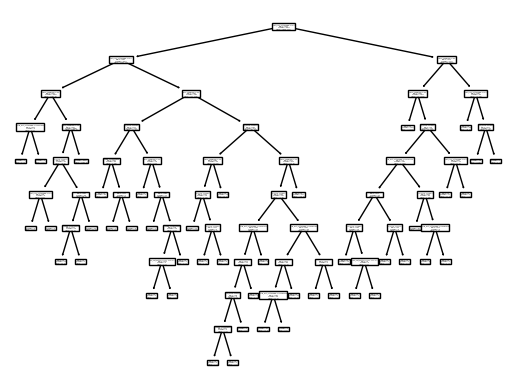

In [6]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, Y_train)

tree.plot_tree(dtree, feature_names= feature_names )

Let's look at how well it makes predictions

Text(50.722222222222214, 0.5, 'Predicted')

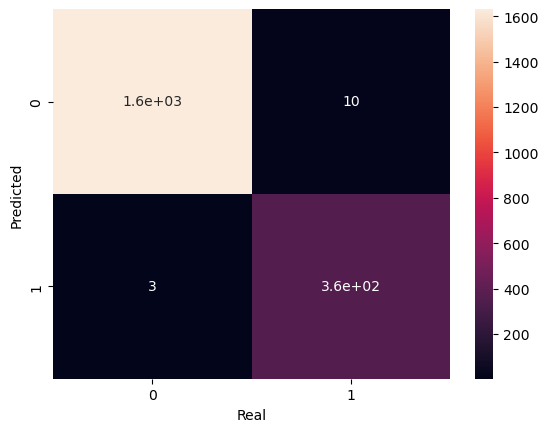

In [69]:
y_pred = dtree.predict(X_test)
CM = confusion_matrix(Y_test ,y_pred)
snc.heatmap(CM, annot=True)
plt.xlabel('Real')
plt.ylabel('Predicted')

While small, our decision tree has a bias towards false positives, where someone who will not default is predicted to default. While this minimizes risk, it may prevent customers that don't default from accessing credit.

### Let's try a logistic regressor instead

This model uses a sigmoid as the activation function, which gives us more flexibility in fitting than the binary decision tree.

In [14]:
lreg = LogisticRegression(random_state=23)
#rescale the data to compress the phase space
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
lreg = lreg.fit(X_train_rescaled, Y_train)


Now testing our regressor:

Text(50.722222222222214, 0.5, 'Predicted')

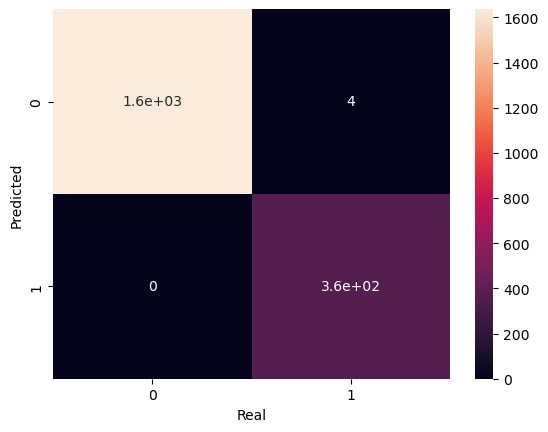

In [17]:
y_pred = lreg.predict(scaler.fit_transform(X_test))

CM = confusion_matrix(Y_test ,y_pred)
snc.heatmap(CM, annot=True)
plt.xlabel('Real')
plt.ylabel('Predicted')

As long as the features have gone through a standard scaler, this model is more accurate than the decision tree. It is still biased towards false positives but even then rarely gave incorrect predictions when used.

### Let's make a function to return the probability of defaulting for both models

In [65]:
def predict_default_probability(customer_features, model, scaler, type = 'LR'):
    
    """Gives the expected default probability for a customer or a series of customers
    
    in: list of customer features
        order: ['credit_lines_outstanding',	
                'loan_amt_outstanding' ,
                'total_debt_outstanding',
                'income',
                'years_employed',
                'fico_score']
        
    in: pre-trained model
    in: str type - LR or Tree
    out: probability """

    
    if type == 'LR': 
        scaled_features = scaler.transform([customer_features])
        predicted_probability = model.predict_proba(scaled_features)
    elif type == 'Tree': 
        predicted_probability = model.predict_proba([customer_features])
    else: raise Exception('You need to choose one of our models')
    
    return predicted_probability[:,1][0]



customer_example = [0,	5221.545193 ,	3915.471226	,78039.38546 ,	5	,605]
predict_default_probability(customer_example, dtree,scaler, type = 'Tree')


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


0.0

### Using our default probability function, let's make a function to return the expected loss

In [66]:
def expected_loss(customer_features, recovery_rate = 0.1):
    """
    Returns the expected loss from defaulting after calculating credit risk
    
    customer_features = ['credit_lines_outstanding',
                        'loan_amt_outstanding',
                        'total_debt_outstanding',
                        'income',
                        'years_employed',
                        'fico_score' ]
    """
    P_default = predict_default_probability(customer_features, lreg, scaler)

    #customer_features[1] is 'loan_amt_outstanding'
    expected_loss = (1 - recovery_rate)*P_default*customer_features[1]
    return expected_loss





In [64]:
#testing for someone who didn't default
expected_loss(customer_example)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1.2979055799555867e-07

In [63]:
defaulter_examples = credit_data[credit_data['default'] ==1]
defaulter_examples= defaulter_examples.drop(['customer_id', 'default'], axis = 1)
defaulter_example = defaulter_examples.iloc[1, :]

expected_loss(defaulter_example.to_list())

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


2971.6517068969342

A customer that is likely to default has a far higher expected loss than one that doesn't. Our functio works!